In [1]:
from trainer import QLearn
import gymnasium as gym

EPISODES = 100000

env = gym.make("Blackjack-v1", render_mode="rgb_array")

q_learn = QLearn(env, alpha=0.1, gamma=1, epsilon=1, epsilon_decay=0.99995, min_epsilon=0.01)
rewards = q_learn.train(episodes=EPISODES, stats_interval=500)

New max of 1.0 in episode 2
Episodes (0, 499): Avg Reward- -0.426
Episodes (500, 999): Avg Reward- -0.4
Episodes (1000, 1499): Avg Reward- -0.404
Episodes (1500, 1999): Avg Reward- -0.438
Episodes (2000, 2499): Avg Reward- -0.414
Episodes (2500, 2999): Avg Reward- -0.368
Episodes (3000, 3499): Avg Reward- -0.26
Episodes (3500, 3999): Avg Reward- -0.348
Episodes (4000, 4499): Avg Reward- -0.37
Episodes (4500, 4999): Avg Reward- -0.296
Episodes (5000, 5499): Avg Reward- -0.35
Episodes (5500, 5999): Avg Reward- -0.37
Episodes (6000, 6499): Avg Reward- -0.268
Episodes (6500, 6999): Avg Reward- -0.294
Episodes (7000, 7499): Avg Reward- -0.346
Episodes (7500, 7999): Avg Reward- -0.354
Episodes (8000, 8499): Avg Reward- -0.256
Episodes (8500, 8999): Avg Reward- -0.358
Episodes (9000, 9499): Avg Reward- -0.3
Episodes (9500, 9999): Avg Reward- -0.356
Episodes (10000, 10499): Avg Reward- -0.324
Episodes (10500, 10999): Avg Reward- -0.286
Episodes (11000, 11499): Avg Reward- -0.248
Episodes (1150

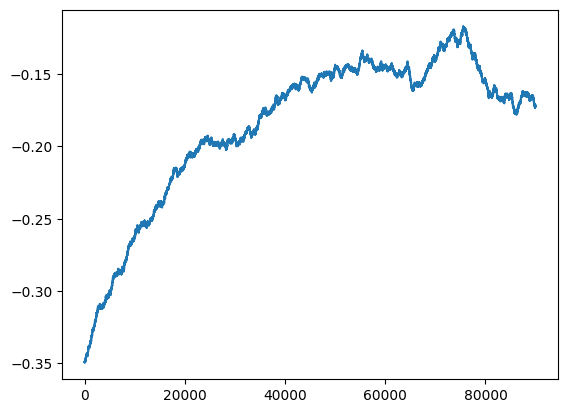

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, int(EPISODES/10)))

In [3]:
from IPython.display import HTML

HTML(q_learn.playback())

/Users/varun/Documents/venvs/3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Playback Return: 0.0


In [4]:
q_learn.eval(episodes=1000)

Average Return over 1000 episodes: -0.139
